# Text classification with preprocessed text: Movie reviews

In [1]:
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.0.0


The dataset has already been preprocessed so that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

In [2]:
(train_data, test_data), info = tfds.load('imdb_reviews/subwords8k',
                                          split = (tfds.Split.TRAIN, tfds.Split.TEST),
                                          as_supervised=True,
                                          with_info=True)

In [3]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [4]:
encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be.

In [6]:
for ts in encoded_string:
    print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


#### Explore the data

In [7]:
for train_example, train_label in train_data.take(1):
    print('Encoded text:', train_example[:10].numpy())
    print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [9]:
encoder.decode(train_example[:10])

"This was an absolutely terrible movie. Don't "

#### Prepare the data for training 

In [10]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, padded_shapes=([None],[])))

test_batches = (
    test_data
    .padded_batch(32, padded_shapes=([None],[])))

Each batch will have a shape of (batch_size, sequence_length).

In [12]:
for example_batch, label_batch in train_batches.take(2):
    print("Batch shape:", example_batch.shape)
    print("label shape:", label_batch.shape)

Batch shape: (32, 1615)
label shape: (32,)
Batch shape: (32, 709)
label shape: (32,)


#### Build the model

In [13]:
model = keras.Sequential([
    keras.layers.Embedding(encoder.vocab_size, 16),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

  * The first layer is an `Embedding layer`. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.
  * Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
  * This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
  * The last layer is densely connected with a single output node. Using the `sigmoid activation function`, this value is a float between 0 and 1, representing a probability, or confidence level. For numerical stability, use the linear activation function that represents the logits.

#### Train the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.6819 - accuracy: 0.5006 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.6179 - accuracy: 0.5571 - val_loss: 0.5913 - val_accuracy: 0.6052
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.5359 - accuracy: 0.6728 - val_loss: 0.5283 - val_accuracy: 0.6687
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.4698 - accuracy: 0.7564 - val_loss: 0.4789 - val_accuracy: 0.7948
Epoch 5/10
782/782 [==============================] - 3s 3ms/step - loss: 0.4174 - accuracy: 0.8064 - val_loss: 0.4413 - val_accuracy: 0.8052
Epoch 6/10
782/782 [==============================] - 3s 3ms/step - loss: 0.3759 - accuracy: 0.8371 - val_loss: 0.4139 - val_accuracy: 0.8281
Epoch 7/10
782/782 [==============================] - 3s 3ms/step - loss: 0.3452 - accuracy: 0.8554 - val_loss: 0.3982 - val_accuracy: 0.863

In [16]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3299 - accuracy: 0.8594
Loss:  0.3299435043750364
Accuracy:  0.85944


#### Plot the training `accuracy` and `loss` during the training epochs

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

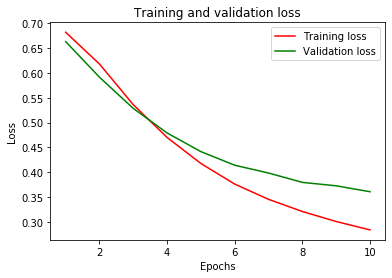

In [21]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

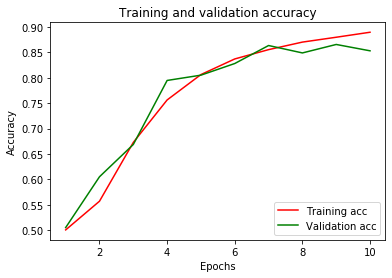

In [22]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()